# Study updates / reverted in Wikidata properties
In this notebook we check the characteristics of claims that were **updated** (modified) or reverted on Wikidata.
This notebook is using the MediaWiki Data Lake version of the mediawiki_history table. 
To learn more about this project please visit this link: https://meta.wikimedia.org/wiki/Research:Identifying_Controversial_Content_in_Wikidata

In [3]:
#loading spark context
import wmfdata
spark = wmfdata.spark.get_session(type='yarn-large')

You are using wmfdata v1.3.2, but v1.3.3 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [2]:
#Check the recent partitions
spark.sql('SHOW PARTITIONS wmf.wikidata_entity').show()

+-------------------+
|          partition|
+-------------------+
|snapshot=2021-12-13|
|snapshot=2021-12-20|
|snapshot=2021-12-27|
|snapshot=2022-01-03|
|snapshot=2022-01-10|
|snapshot=2022-01-17|
|snapshot=2022-01-24|
|snapshot=2022-01-31|
|snapshot=2022-02-07|
|snapshot=2022-02-14|
|snapshot=2022-02-21|
|snapshot=2022-02-28|
+-------------------+



In [3]:
#Get english labels for properties
labelsProp = spark.sql("""SELECT id as prop, labels.{lang} as label
        FROM wmf.wikidata_entity
      WHERE snapshot = '2022-02-14'
      AND substr(id,1,1) = 'P'
      """.format(lang='en'))
labelsProp.cache()

DataFrame[prop: string, label: string]

In [4]:
labelsProp.count()

9649

In [5]:
labelsProppd = labelsProp.toPandas()

## Check changes (updates) on Wikidata claims

In [13]:
## get all edits on wikidatawiki matchingwbsetclaim-update:

changes  = spark.sql('''SELECT page_title,revision_id,event_comment,revision_parent_id
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' AND snapshot = '2022-01' AND LOWER(event_comment)
            LIKE "%wbsetclaim-update:%"''')

In [14]:
changes.count()

20293223

## Changes per topic
Changes here is used to refer claims that has been updated 

In [16]:
#Check topics table
topics = spark.sql('SELECT DISTINCT qid,topic FROM isaacj.article_topics_outlinks_2021_07 WHERE score > 0.5')


In [17]:
changesPerTopic = changes.join(topics.select('Qid','topic'),topics['Qid']==changes['page_title'])

In [18]:
changesPerTopicCount =  changesPerTopic.select('topic').groupBy('topic').count().orderBy('count', ascending=False)

In [19]:
changesPerTopicCount.show(truncate=False)

+-------------------------------------------+-------+
|topic                                      |count  |
+-------------------------------------------+-------+
|Geography.Regions.Europe.Europe*           |6872715|
|Culture.Biography.Biography*               |5930030|
|Geography.Regions.Asia.Asia*               |3264306|
|Geography.Regions.Americas.North_America   |2859501|
|Geography.Geographical                     |2470041|
|Geography.Regions.Europe.Western_Europe    |2253574|
|Culture.Media.Media*                       |2161573|
|Geography.Regions.Europe.Eastern_Europe    |1853926|
|STEM.STEM*                                 |1820012|
|Geography.Regions.Europe.Northern_Europe   |1506435|
|Geography.Regions.Europe.Southern_Europe   |1445594|
|Culture.Sports                             |1267779|
|Culture.Biography.Women                    |1151414|
|Geography.Regions.Asia.North_Asia          |1097013|
|Culture.Visual_arts.Visual_arts*           |1078634|
|History_and_Society.History

In [20]:
totalPagesPerTopic  = topics.select('topic').groupBy('topic').count().orderBy('count', ascending=False)

In [21]:
percentagePagesPerTopic= changesPerTopicCount.join(totalPagesPerTopic.selectExpr('topic','count as total'),'topic')


In [22]:
percentagePagesPerTopic.show()

+--------------------+-------+-------+
|               topic|  count|  total|
+--------------------+-------+-------+
|Geography.Regions...|  63924|  73200|
|Culture.Visual_ar...| 550325| 406297|
|Culture.Visual_ar...| 154550| 115063|
|Geography.Geograp...|2470041|2382626|
|Geography.Regions...| 101079| 142665|
|STEM.Earth_and_en...| 210647| 188955|
|Geography.Regions...| 160970| 161428|
|Geography.Regions...| 808785|1153552|
|STEM.Medicine_&_H...| 186821| 178437|
|History_and_Socie...| 736225| 501145|
|Culture.Internet_...| 236855|  99461|
|Geography.Regions...| 213658| 247658|
|Geography.Regions...|  89078| 114484|
|Geography.Regions...|  99382| 111123|
|Culture.Media.Ent...| 236881| 104013|
| Culture.Media.Music| 714706| 857290|
|History_and_Socie...| 385180| 334637|
|Geography.Regions...|1853926|1628827|
|Culture.Food_and_...|  83155| 109039|
|History_and_Socie...| 810398| 466000|
+--------------------+-------+-------+
only showing top 20 rows



In [23]:
import pyspark.sql.functions as F

percentagePagesPerTopic = percentagePagesPerTopic.withColumn("ratio", (F.col("count") / F.col("total"))).orderBy('ratio', ascending=False)

In [24]:
percentagePagesPerTopic.show(truncate=False)

+-------------------------------------------+-------+-------+------------------+
|topic                                      |count  |total  |ratio             |
+-------------------------------------------+-------+-------+------------------+
|Culture.Media.Software                     |204350 |50190  |4.071528192867105 |
|Culture.Internet_culture                   |236855 |99461  |2.381385668754587 |
|STEM.Computing                             |245252 |104773 |2.3407939068271406|
|STEM.Libraries_&_Information               |47238  |20248  |2.3329711576451997|
|Culture.Media.Entertainment                |236881 |104013 |2.2774172459211828|
|Culture.Biography.Women                    |1151414|528111 |2.1802499853250548|
|History_and_Society.Society                |262137 |120938 |2.1675321238981957|
|Culture.Media.Video_games                  |128117 |73272  |1.7485123921825527|
|History_and_Society.History                |810398 |466000 |1.7390515021459227|
|STEM.Technology            

# Check properties **updated**
Here we focus not in the full claim but in the properties that has been updated


In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re 
import pyspark.sql.functions as F


@udf("String")
def findProp(t):
    try:
        return re.search("Property:(\w+)\]",t).group(1)
    except:
        return ''

changesWithProp = changes.withColumn("prop", findProp(F.col("event_comment")))

In [26]:
changesWithPropCount = changesWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False)
#changesWithPropCount.join(labelsProp,'prop').show(truncate=False)
changesWithPropCount.show()

+-----+-------+
| prop|  count|
+-----+-------+
|  P31|1822155|
| P625|1674324|
|  P17|1074305|
| P569| 750219|
| P131| 665811|
|  P39| 591884|
| P570| 469001|
|  P18| 460093|
| P106| 446252|
|P1082| 433482|
|P3083| 355127|
|  P19| 346689|
|P2044| 330826|
|P1435| 284887|
| P735| 268251|
|  P69| 260563|
| P856| 259537|
| P166| 257248|
| P571| 172606|
|  P27| 163773|
+-----+-------+
only showing top 20 rows



In [27]:
changesWithPropCountpd = changesWithPropCount.toPandas()


In [66]:
import pandas as pd
pd.merge(labelsProppd,changesWithPropCountpd,on='prop').sort_values('count',ascending=False)[0:30]

prop                                              label    count
1671    P31                                      "instance of"  1675925
1844   P625                              "coordinate location"  1640815
3336    P17                                          "country"  1061046
4284   P569                                    "date of birth"   659918
4935   P131  "located in the administrative territorial ent...   621781
2066    P39                                    "position held"   523067
896    P570                                    "date of death"   411545
3874  P1082                                       "population"   410083
4545    P18                                            "image"   398399
6799   P106                                       "occupation"   388226
824   P2044                        "elevation above sea level"   328179
5383    P19                                   "place of birth"   296123
4433  P1435                             "heritage designation"   270992
4170   P166                                   "award received"   232167
3726    P69                                      "educated at"   230221
973    P735                                       "given name"   229639
1531   P856                                 "official website"   221670
2237  P3083                                        "SIMBAD ID"   159434
1679   P571                                        "inception"   148101
4882    P27                           "country of citizenship"   146261
413    P373                                 "Commons category"   137817
1786    P54                            "member of sports team"   134920
4818    P20                                   "place of death"   129791
6064  P8687                           "social media followers"   128507
5839   P108                                         "employer"   122352
6361   P348                      "software version identifier"   122112
6276   P716                   "JPL Small-Body Database SPK-ID"   117076
4611   P161                                      "cast member"   109438
2152   P225                                       "taxon name"   105172
3258   P197                                 "adjacent station"   105148

In [28]:
changesPerProp = changesWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False)

In [29]:
changesWithProp.show()

+----------+-----------+--------------------+------------------+-----+
|page_title|revision_id|       event_comment|revision_parent_id| prop|
+----------+-----------+--------------------+------------------+-----+
| Q21621919|  851428230|/* wbsetclaim-upd...|         851428172| P136|
| Q75531325| 1317830356|/* wbsetclaim-upd...|        1317830262|P1038|
| Q21621919| 1182479869|/* wbsetclaim-upd...|        1179989063|  P31|
| Q75531325| 1317828657|/* wbsetclaim-upd...|        1317828625|P3716|
| Q21608026| 1313815179|/* wbsetclaim-upd...|        1313814799| P166|
| Q34829513|  773861510|/* wbsetclaim-upd...|         773861497|  P31|
|   Q489147|  147270549|/* wbsetclaim-upd...|         138433393| P910|
|   Q374895|  480005545|/* wbsetclaim-upd...|         480005498|P1705|
|     Q7547| 1429583064|/* wbsetclaim-upd...|        1429582996| P575|
| Q29221341| 1077489396|/* wbsetclaim-upd...|         745696826|P1435|
| Q96616000| 1278246229|/* wbsetclaim-upd...|        1278246125|P1476|
| Q494

In [30]:
changesWithProp.select('page_title','prop').groupby('page_title','prop').count().orderBy('count', ascending=False).show()

+----------+-----+-----+
|page_title| prop|count|
+----------+-----+-----+
| Q85408509|P1082| 1126|
| Q87119811|P8011|  995|
|      Q698| P348|  803|
|      Q777| P348|  758|
| Q86913546|P8011|  687|
| Q84081307|P1603|  667|
| Q87119811|P1603|  664|
| Q87119811|P1120|  656|
| Q86913546|P1603|  623|
| Q86913546|P1120|  609|
|  Q4115189|  P31|  608|
| Q87119811|P8010|  605|
| Q86913546|P8010|  605|
|Q106703494|P4330|  602|
| Q21645578| P106|  590|
| Q21645578|  P31|  590|
| Q87250860|P8011|  580|
| Q84081307|P1120|  576|
|    Q14579| P348|  573|
| Q87250860|P1120|  555|
+----------+-----+-----+
only showing top 20 rows



## Changes from Jan to  July 2021 
Now, instead of looking the full history of Wikipedia we focus on a shorter span of time

In [36]:
changesJuly  = spark.sql('''SELECT TO_TIMESTAMP(event_timestamp) as event_timestamp, page_title,revision_id,event_comment,revision_parent_id
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' AND snapshot = '2021-07' AND LOWER(event_comment)
            LIKE "%wbsetclaim-update:%"
            AND TO_TIMESTAMP(event_timestamp) > TO_TIMESTAMP('2021-01-01')
            AND TO_TIMESTAMP(event_timestamp) < TO_TIMESTAMP('2021-08-01')
            ''')

In [31]:
changesJuly.count()

NameError: name 'changesJuly' is not defined

In [ ]:
spark.sql('''show partitions wmf.wikidata_item_page_link 
''').show()

In [43]:
changesJulyWithProp = changesJuly.withColumn("prop", findProp(F.col("event_comment")))

In [44]:
changesJulyWithProp.select('page_title','prop').groupby('page_title','prop').count().orderBy('count', ascending=False).show()

+----------+-----+-----+
|page_title| prop|count|
+----------+-----+-----+
|Q106703494|P4330|  598|
|Q104161786| P710|  496|
|Q104161900| P710|  452|
| Q61778309| P710|  392|
| Q87119811|P8011|  390|
|Q104408128| P710|  388|
| Q85408509|P1082|  353|
|Q104033242| P710|  313|
|Q101460321| P710|  311|
| Q86913546|P8011|  279|
| Q23701776| P710|  273|
|   Q570307| P710|  255|
|Q101085154| P710|  245|
|Q101438858| P710|  235|
|Q103963527| P710|  224|
| Q86913546|P1603|  220|
|Q101438496| P710|  219|
|  Q2134877| P710|  217|
| Q86913546|P8010|  216|
|   Q546013| P710|  216|
+----------+-----+-----+
only showing top 20 rows



In [67]:
changesJulyWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+------+
| prop| count|
+-----+------+
|  P31|157094|
|P8687|128503|
| P569|128369|
|P1082| 85746|
|P3083| 81218|
| P570| 80367|
| P106| 73621|
|  P39| 64158|
|  P19| 63213|
|  P18| 59652|
|  P69| 56579|
| P131| 55195|
| P856| 50641|
| P625| 42877|
| P735| 36283|
| P166| 32684|
|  P20| 27127|
| P571| 25981|
| P108| 24652|
|  P54| 22586|
+-----+------+
only showing top 20 rows



In [35]:
itemsWithSiteLink =  spark.sql ('''
SELECT DISTINCT item_id FROM  wmf.wikidata_item_page_link WHERE 
snapshot = '2021-09-27'
''')


In [39]:
changesJulyWithPage = changesJuly.join(itemsWithSiteLink,changesJuly['page_title']==itemsWithSiteLink['item_id'])

In [40]:
changesJulyWithPage.count()


1712159

In [41]:
changesJulyWithPageWithProp = changesJulyWithPage.withColumn("prop", findProp(F.col("event_comment")))

In [42]:
changesJulyWithPageWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+------+
| prop| count|
+-----+------+
|P8687|117115|
|  P31|107913|
| P569| 89169|
|P1082| 84926|
| P570| 59992|
|  P18| 56084|
|  P39| 51542|
| P106| 45190|
|  P19| 44539|
| P131| 38675|
| P856| 36996|
|  P69| 33826|
| P625| 32591|
| P166| 29268|
| P735| 23766|
|  P54| 21425|
|  P20| 20969|
| P590| 16788|
|  P27| 15644|
|P1435| 15472|
+-----+------+
only showing top 20 rows



In [65]:
changesJulypd = changesJulyWithPageWithProp.toPandas()

In [67]:
changesJulypd.columns

Index(['event_timestamp', 'page_title', 'revision_id', 'event_comment',
       'revision_parent_id', 'item_id', 'prop'],
      dtype='object')

## Check reverts / reverting
Now we focus on studying edits that has been reverted (or reverts others)

In [68]:
# Get the reverted props
import pyspark.sql.functions as F


reverted = spark.sql('''SELECT page_title,revision_id,event_comment,revision_parent_id
            FROM wmf.mediawiki_history 
            WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND revision_is_identity_reverted = 1
            ''')

revertedWithProp = reverted.withColumn("prop", findProp(F.col("event_comment")))

revertedPropCount = revertedWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False)
revertedPropCount.show()

+-----+-------+
| prop|  count|
+-----+-------+
|     |4810602|
|  P31| 483011|
|P2093| 206874|
|P1545| 206475|
|P2860| 181060|
|P2214| 145383|
| P106| 122756|
| P108| 114114|
|  P18| 112696|
| P569| 111750|
| P571| 110848|
| P580| 107387|
|  P17| 101940|
| P364|  98632|
| P921|  97243|
| P373|  92000|
| P131|  89904|
| P625|  82074|
|P1343|  75308|
| P407|  71909|
+-----+-------+
only showing top 20 rows



In [69]:
revertedPropCount = revertedWithProp.select('prop').groupBy('prop').count().orderBy('count', ascending=False).withColumnRenamed('count','prop_reverts_count')


In [70]:
revertedWithProp.show()

+----------+-----------+--------------------+------------------+-----+
|page_title|revision_id|       event_comment|revision_parent_id| prop|
+----------+-----------+--------------------+------------------+-----+
| Q62985082| 1183170295|/* wbsetdescripti...|        1149839269|     |
|     P4289|  682765046|/* wbsetclaimvalu...|         682765039|P2302|
|   Q233453|  857318393|/* wbsetclaim-upd...|         857318032|P3065|
| Q38236886|  862043256|/* wbcreateclaim-...|         844135863| P149|
|   Q625912|  441308222|/* wbsetreference...|         441308216| P213|
|Q106049770| 1385815028|/* wbsetlabel-set...|        1385688896|     |
| Q27075323|  411732584|/* wbsetreference...|         411685264|P1843|
| Q26250251|  382392931|/* wbsetsitelink-...|         382391717|     |
| Q47502505|  852456849|/* wbsetqualifier...|         835168449| P580|
| Q26210647|  369326259|                null|         363904851|     |
|  Q6587409| 1263577142|/* wbsetsitelink-...|        1130247551|     |
| Q211

In [71]:
revertedWithProp.count()

11142972

In [72]:
# % without of reverts without prop
4810602/ 11142972

0.43171624230950234

In [7]:
@udf("String")
def findCommentSummary(t):
    try:
        return re.search("\* ([\w-]+)",t).group(1)
    except:
        return ''



In [74]:
revertedComment = revertedWithProp.select('event_comment').withColumn("summaryType", findCommentSummary(F.col("event_comment")))
revertedCommentCountpd = revertedComment.select('summaryType').groupBy('summaryType').count().orderBy('count', ascending=False).toPandas()

In [75]:
#Here I cound the edits summaries
editsSumamryAll = spark.sql('''SELECT event_comment 
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            ''').withColumn("summaryType", findCommentSummary(F.col("event_comment")))

editsSumamryAllCount = editsSumamryAll.select('summaryType').groupBy('summaryType').count().orderBy('count', ascending=False)


In [76]:
editsSumamryAllCountPd = editsSumamryAllCount.toPandas()

In [77]:
editsSumamryAllCountPd['percentage'] = 100 * editsSumamryAllCountPd['count'] / editsSumamryAllCountPd['count'].sum()

In [78]:
revertedCommentCountpd['percentage'] = 100 * revertedCommentCountpd['count'] / revertedCommentCountpd['count'].sum()

In [79]:
import pandas as pd
editsSummaryAllVsReverted = pd.merge(editsSumamryAllCountPd,revertedCommentCountpd,on='summaryType',suffixes=['_total','_reverted'])

In [80]:
editsSummaryAllVsReverted['ratioChange'] = editsSummaryAllVsReverted['percentage_reverted'] / editsSummaryAllVsReverted['percentage_total']
editsSummaryAllVsReverted['diffChange'] = editsSummaryAllVsReverted['percentage_total'] -  editsSummaryAllVsReverted['percentage_reverted'] 


In [81]:
editsSummaryAllVsRevertedTop = editsSummaryAllVsReverted.sort_values(by='count_total',ascending=False)[0:50]

In [82]:
editsSummaryAllVsRevertedTop.sort_values(by='ratioChange',ascending=False)[0:10]

summaryType  count_total  percentage_total  \
45  wbsetlabeldescriptionaliases       115421          0.007851   
31                          undo      1180908          0.080321   
42                       restore       152900          0.010400   
28          wbsetsitelink-remove      1696691          0.115403   
38              wbsetaliases-set       536651          0.036501   
17               wbsetclaimvalue      7361663          0.500716   
10                                   23673331          1.610180   
32       wbsetdescription-remove      1156657          0.078672   
33             wbsetlabel-remove       874549          0.059484   
12             wbsetclaim-update     18236723          1.240401   

    count_reverted  percentage_reverted  ratioChange  diffChange  
45           22006             0.197488    25.155912   -0.189637  
31          214869             1.928292    24.007199   -1.847970  
42           24245             0.217581    20.921773   -0.207181  
28          135505             1.216058    10.537470   -1.100655  
38           26208             0.235198     6.443558   -0.198696  
17          322826             2.897127     5.785973   -2.396411  
10          900528             8.081578     5.019051   -6.471398  
32           33686             0.302307     3.842631   -0.223635  
33           25098             0.225236     3.786507   -0.165752  
12          492851             4.422976     3.565764   -3.182576

In [83]:
editsSummaryAllVsRevertedTop.sort_values(by='diffChange',ascending=True)[0:20]

summaryType  count_total  percentage_total  \
10                                   23673331          1.610180   
0           wbcreateclaim-create    275343300         18.727926   
12             wbsetclaim-update     18236723          1.240401   
5              wbsetclaim-create     75091475          5.107470   
17               wbsetclaimvalue      7361663          0.500716   
8             wbsetqualifier-add     46856903          3.187049   
31                          undo      1180908          0.080321   
9          wbremoveclaims-remove     31740401          2.158875   
28          wbsetsitelink-remove      1696691          0.115403   
11             wbsetsitelink-add     22490635          1.529737   
14                wbsetlabel-set     11757297          0.799692   
18         clientsitelink-update      5578698          0.379444   
16              wbsetaliases-add      7902457          0.537499   
22               wbmergeitems-to      3061316          0.208220   
26         clientsitelink-remove      1836090          0.124885   
32       wbsetdescription-remove      1156657          0.078672   
42                       restore       152900          0.010400   
38              wbsetaliases-set       536651          0.036501   
45  wbsetlabeldescriptionaliases       115421          0.007851   
33             wbsetlabel-remove       874549          0.059484   

    count_reverted  percentage_reverted  ratioChange  diffChange  
10          900528             8.081578     5.019051   -6.471398  
0          2686699            24.111153     1.287444   -5.383227  
12          492851             4.422976     3.565764   -3.182576  
5           842558             7.561340     1.480447   -2.453870  
17          322826             2.897127     5.785973   -2.396411  
8           619000             5.555071     1.743014   -2.368022  
31          214869             1.928292    24.007199   -1.847970  
9           376192             3.376047     1.563799   -1.217172  
28          135505             1.216058    10.537470   -1.100655  
11          275283             2.470463     1.614959   -0.940726  
14          184146             1.652575     2.066515   -0.852883  
18           94679             0.849675     2.239260   -0.470230  
16           99583             0.893684     1.662673   -0.356186  
22           56276             0.505036     2.425486   -0.296815  
26           39357             0.353200     2.828211   -0.228316  
32           33686             0.302307     3.842631   -0.223635  
42           24245             0.217581    20.921773   -0.207181  
38           26208             0.235198     6.443558   -0.198696  
45           22006             0.197488    25.155912   -0.189637  
33           25098             0.225236     3.786507   -0.165752

In [84]:
editsSummaryAllVsReverted.corr()

count_total  percentage_total  count_reverted  \
count_total             1.000000          1.000000        0.839953   
percentage_total        1.000000          1.000000        0.839953   
count_reverted          0.839953          0.839953        1.000000   
percentage_reverted     0.839953          0.839953        1.000000   
ratioChange            -0.053829         -0.053829       -0.056758   
diffChange              0.332527          0.332527       -0.232472   

                     percentage_reverted  ratioChange  diffChange  
count_total                     0.839953    -0.053829    0.332527  
percentage_total                0.839953    -0.053829    0.332527  
count_reverted                  1.000000    -0.056758   -0.232472  
percentage_reverted             1.000000    -0.056758   -0.232472  
ratioChange                    -0.056758     1.000000    0.002164  
diffChange                     -0.232472     0.002164    1.000000

<AxesSubplot:xlabel='count_total', ylabel='count_reverted'>

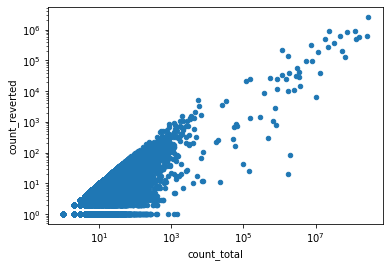

In [85]:
editsSummaryAllVsReverted.plot.scatter(x='count_total',y='count_reverted',logx=True,logy=True)

In [86]:
## 
users_reverted = spark.sql('''SELECT event_user_text, event_comment
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND revision_is_identity_reverted = 1
            ''')

In [ ]:
users_reverted.select('event_user_id').groupBy('event_user_id').count().orderBy('count', ascending=False).show()

In [133]:
users_reverted.select('event_user_text').groupBy('event_user_text').count().orderBy('count', ascending=False).show()

+------------------+------+
|   event_user_text| count|
+------------------+------+
|             Harej|515136|
|             KrBot|499923|
|          SuccuBot|309032|
|   Daniel Mietchen|257139|
|    Reinheitsgebot|250717|
|             Sic19|237835|
|          GeneDBot|204913|
|       ListeriaBot|204520|
|      Research Bot|199300|
|        Scidudebot|192772|
|QuickStatementsBot|162244|
|          DeltaBot|124027|
|             Jura1|109858|
|          BotNinja|109844|
|       Edoderoobot|107321|
|          Epìdosis| 99382|
|            Ghuron| 90733|
|          Nvrandow| 84628|
|            EloBot| 67102|
|             PLbot| 64059|
+------------------+------+
only showing top 20 rows



In [153]:
users_reverting = spark.sql('''SELECT event_user_text, event_comment
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND revision_is_identity_revert = 1
            ''')

In [135]:
users_reverting.select('event_user_text').groupBy('event_user_text').count().orderBy('count', ascending=False).show()

+------------------+------+
|   event_user_text| count|
+------------------+------+
|             KrBot|393387|
|          GeneDBot|357530|
|             Jura1|144370|
|       ListeriaBot|140803|
|          Epìdosis|121351|
|             PLbot| 69903|
|QuickStatementsBot| 68729|
|             Harej| 63530|
|          MatSuBot| 62092|
|             Sic19| 58110|
|          DeltaBot| 57777|
|            Ghuron| 56559|
|        Scidudebot| 54712|
|          Hogü-456| 46218|
|          Nvrandow| 43058|
|          BotNinja| 41412|
|          Mahir256| 38076|
|               YMS| 37407|
|        Infovarius| 37119|
|     Thomasstjerne| 34285|
+------------------+------+
only showing top 20 rows



In [143]:
users_reverted_count = users_reverted.select('event_user_text').groupBy('event_user_text').count().orderBy('count', ascending=False).withColumnRenamed('count','reverts_count')
users_reverting_count = users_reverting.select('event_user_text').groupBy('event_user_text').count().orderBy('count', ascending=False).withColumnRenamed('count','reverting_count')

reverted_reverting_counts = users_reverted_count.join(users_reverting_count,'event_user_text').toPandas()

In [144]:
reverted_reverting_counts.corr()

reverts_count  reverting_count
reverts_count         1.000000         0.703481
reverting_count       0.703481         1.000000

## Reverts Bots vs people 
Counting if bots tends to be more reverted and reverting than no bots 

In [154]:
# Who reverts the most
# 0: human
# 1,2: bots
# -1: null (error?)
reverting_user_type = spark.sql('''SELECT SIZE(event_user_is_bot_by) as is_bot, COUNT(*)
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND revision_is_identity_revert = 1
            AND event_entity = 'revision'
            GROUP BY is_bot
            ''')
reverting_user_type.show()

+------+--------+
|is_bot|count(1)|
+------+--------+
|    -1|  137857|
|     0| 3437603|
|     2| 1656338|
|     1|  221137|
+------+--------+



In [157]:
#ratio  of humans reverting
3437603/(3437603+1656338+221137)

0.6467643560451982

In [155]:
#who are more reverted
reverted_user_type = spark.sql('''SELECT SIZE(event_user_is_bot_by) as is_bot, COUNT(*)
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND revision_is_identity_reverted = 1
            AND event_entity = 'revision'
            GROUP BY is_bot
            ''')
reverted_user_type.show()

+------+--------+
|is_bot|count(1)|
+------+--------+
|    -1|  896835|
|     0| 6357640|
|     2| 3411431|
|     1|  477066|
+------+--------+



In [158]:
#ratio of humans, in the total reverted
6357640/(6357640+3411431+477066)

0.6204914105677095

In [156]:
# general count of edits in each group
edits_user_type = spark.sql('''SELECT SIZE(event_user_is_bot_by) as is_bot, COUNT(*)
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2021-07'
            AND event_entity = 'revision'
            GROUP BY is_bot
            ''')
edits_user_type.show()

+------+---------+
|is_bot| count(1)|
+------+---------+
|    -1|  6563790|
|     0|621899883|
|     2|688346342|
|     1|153418468|
+------+---------+



In [159]:
#ratio of humans in the total edits
621899883/(621899883+688346342+153418468)

0.42489231719139375

# Working Just from 2021 
(to remove noise and make computation easier)

In [8]:
editsFrom2021 =  spark.sql('''SELECT TIMESTAMP(event_timestamp), 
                                    page_title,
                                    event_comment,
                                    revision_parent_id, 
                                    SIZE(event_user_is_bot_by) as is_bot,
                                    revision_is_identity_reverted,
                                    revision_is_identity_revert,
                                    revision_first_identity_reverting_revision_id,
                                    revision_seconds_to_identity_revert,
                                    event_user_text,
                                    event_user_revision_count,
                                    page_revision_count,
                                    page_seconds_since_previous_revision,
                                    datediff(TIMESTAMP(event_timestamp),TIMESTAMP(event_user_creation_timestamp)) AS user_age,
                                    datediff(TIMESTAMP(event_timestamp),TIMESTAMP(page_first_edit_timestamp)) AS page_age
                                    
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' 
            AND wiki_db = 'wikidatawiki' 
            AND snapshot = '2022-02' 
            AND TIMESTAMP(event_timestamp) > TIMESTAMP('2021-01-01')
            ''')

editsFrom2021 = editsFrom2021.withColumn("summaryType", findCommentSummary(F.col("event_comment")))
editsFrom2021 = editsFrom2021.withColumn("prop", findProp(F.col("event_comment")))
editsFrom2021 = editsFrom2021.drop('event_comment')

In [7]:
!hadoop fs -mkdir WikidataControversy
editsFrom2021.write.parquet('WikidataControversy/editsFrom2021.parquet',mode='overwrite')

mkdir: `WikidataControversy': File exists


In [9]:
editsFrom2021 = spark.read.parquet('WikidataControversy/editsFrom2021.parquet')

In [3]:
editsFrom2021.select('is_bot').groupBy('is_bot').count().orderBy('count', ascending=False).show()

+------+--------+
|is_bot|   count|
+------+--------+
|     0|78543398|
|     2|54474494|
|     1| 4192956|
|    -1|  828136|
+------+--------+



In [4]:
# % of edits done by humans in 2021
78543398 / (78543398 + 54474494 + 4192956)

0.5724284861208642

In [221]:
editsFrom2021.where(editsFrom2021['revision_is_identity_reverted'] == True).select('is_bot').groupBy('is_bot').count().orderBy('count', ascending=False).show()

+------+------+
|is_bot| count|
+------+------+
|     0|561191|
|     2|446693|
|    -1|108588|
|     1|  3344|
+------+------+



In [222]:
# % of humans
1092504 / (1092504+518707+21343)

0.66919930366775

In [223]:
editsFrom2021.where(editsFrom2021['revision_is_identity_revert'] == True).select('is_bot').groupBy('is_bot').count().orderBy('count', ascending=False).show()

+------+------+
|is_bot| count|
+------+------+
|     0|438363|
|     2|378097|
|    -1| 24238|
|     1|  2059|
+------+------+



In [224]:
# % of humans
748808 / (748808+365158+13542)

0.6641265516519617

In [225]:
#print 
editsFrom2021.where((editsFrom2021['revision_is_identity_revert'] == True) & (editsFrom2021['is_bot'] == 0)).\
            select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+------+
| prop| count|
+-----+------+
|     |287397|
|P3606| 34300|
|  P31|  9210|
|  P17|  3495|
|  P18|  2452|
|P9097|  1892|
| P106|  1818|
| P373|  1782|
|P1705|  1662|
|P9047|  1563|
| P569|  1532|
|P8814|  1473|
| P279|  1300|
| P921|  1293|
| P971|  1131|
| P131|  1118|
| P625|  1090|
| P571|  1085|
| P570|  1072|
| P735|  1035|
+-----+------+
only showing top 20 rows



In [227]:
editsFrom2021.where((editsFrom2021['revision_is_identity_revert'] == True) & (editsFrom2021['is_bot'] > 0)).\
            select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+------+
| prop| count|
+-----+------+
|     |278251|
|P2214| 31679|
|P2860| 16976|
|P3782|  7146|
| P921|  6123|
|P2094|  5393|
|P7959|  4260|
| P361|  3903|
|P3606|  3449|
| P348|  3181|
|P1412|  2486|
|  P31|  2056|
| P971|  1319|
|  P18|  1281|
|P3151|   822|
|P8363|   821|
|P6018|   569|
| P214|   508|
| P735|   445|
|P7763|   432|
+-----+------+
only showing top 20 rows



In [231]:
#Props edited in general (no reverted) by bots
editsFrom2021.where(editsFrom2021['is_bot'] > 0).\
            select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+--------+
| prop|   count|
+-----+--------+
|     |38506720|
|P2671| 5208033|
|P9157| 1049030|
|  P31|  805670|
| P921|  600622|
| P850|  513313|
|P8687|  466282|
| P186|  367506|
|P3606|  359137|
|P2860|  330024|
|P1476|  325420|
|P2214|  313410|
|P6177|  308494|
| P131|  303550|
| P225|  299836|
| P105|  297321|
| P171|  294476|
|P4985|  266756|
| P846|  255153|
| P569|  222975|
+-----+--------+
only showing top 20 rows



In [232]:
#Props edited in general (no reverted) by humans
editsFrom2021.where(editsFrom2021['is_bot'] == 0).\
            select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+--------+
| prop|   count|
+-----+--------+
|     |49407743|
| P921| 2505702|
| P646| 1837284|
|  P31| 1617157|
|P1412| 1098148|
|P2671|  780600|
|  P21|  642839|
| P735|  639328|
| P106|  634366|
|P1082|  490683|
| P580|  476352|
| P734|  429278|
| P585|  343097|
|  P18|  328603|
| P131|  310841|
|  P17|  305844|
| P356|  301768|
| P932|  295619|
| P569|  281406|
| P459|  273933|
+-----+--------+
only showing top 20 rows



## Using ML to predict reverts
Here I create a balance dataset to train an ML model and check what is the predictability of reverts and the main features that can be used for that aim

In [10]:
editsReverted2021Pd = editsFrom2021.where(editsFrom2021['revision_is_identity_reverted'] == True).toPandas()

In [13]:
editsReverted2021Pd.shape

(1119816, 16)

In [14]:
editsReverted2021Pd.describe()

revision_parent_id        is_bot  \
count        1.119816e+06  1.119816e+06   
mean         1.363851e+09  7.038138e-01   
std          9.435958e+07  1.095535e+00   
min          0.000000e+00 -1.000000e+00   
25%          1.338598e+09  0.000000e+00   
50%          1.380140e+09  0.000000e+00   
75%          1.427333e+09  2.000000e+00   
max          1.470805e+09  2.000000e+00   

       revision_first_identity_reverting_revision_id  \
count                                   1.119816e+06   
mean                                    1.411667e+09   
std                                     3.722748e+07   
min                                     1.332767e+09   
25%                                     1.375084e+09   
50%                                     1.415732e+09   
75%                                     1.440805e+09   
max                                     1.470807e+09   

       revision_seconds_to_identity_revert  event_user_revision_count  \
count                         1.119816e+06               1.011228e+06   
mean                          9.898329e+05               9.826111e+06   
std                           1.743531e+06               1.749390e+07   
min                           0.000000e+00               1.000000e+00   
25%                           8.950000e+02               2.227375e+04   
50%                           8.819250e+04               5.121405e+05   
75%                           1.381943e+06               1.218350e+07   
max                           1.822569e+07               9.674516e+07   

       page_revision_count  page_seconds_since_previous_revision  \
count         1.119816e+06                          1.119816e+06   
mean          8.416796e+03                          5.417413e+06   
std           5.579272e+04                          1.146560e+07   
min           2.000000e+00                          0.000000e+00   
25%           1.000000e+01                          3.100000e+01   
50%           2.700000e+01                          8.672000e+04   
75%           9.500000e+01                          4.596962e+06   
max           4.628670e+05                          2.655375e+08   

            user_age      page_age  
count  779321.000000  1.119791e+06  
mean     1507.796881  1.618980e+03  
std      1094.200933  1.166636e+03  
min         0.000000  0.000000e+00  
25%       587.000000  5.710000e+02  
50%      1363.000000  1.412000e+03  
75%      2674.000000  2.963000e+03  
max      3199.000000  5.658000e+03

In [11]:
editsSample2021Pd = editsFrom2021.sample(0.009).toPandas()

In [16]:
editsSample2021Pd.shape

(1242162, 16)

In [12]:
import pandas as pd
editsSample2021Balenced = pd.concat([editsReverted2021Pd,editsSample2021Pd])

In [13]:
editsSample2021Balenced['revision_is_identity_reverted'].value_counts()

False    1232400
True     1129941
Name: revision_is_identity_reverted, dtype: int64

In [19]:
#Here I keep the most common classes for caterorical types
summaryTypesTop = editsSample2021Balenced.summaryType.value_counts().reset_index(name="count").query("count > 100")['index'].tolist()
propsTop = editsSample2021Balenced.prop.value_counts().reset_index(name="count").query("count > 100")['index']
editsSample2021BalencedClean = editsSample2021Balenced[editsSample2021Balenced['prop'].isin(propsTop)]
editsSample2021BalencedClean = editsSample2021BalencedClean[editsSample2021BalencedClean['summaryType'].isin(summaryTypesTop)]
# defining training and label col
training_cols = ['is_bot','prop','summaryType','page_age','user_age','page_revision_count']
y_col = 'revision_is_identity_reverted'
cols_to_keep = training_cols + [y_col]
editsSample2021BalencedClean = editsSample2021BalencedClean[cols_to_keep]
                                                         

In [20]:
editsSample2021BalencedClean.dropna()[y_col].value_counts()

False    1124970
True      746372
Name: revision_is_identity_reverted, dtype: int64

In [88]:

nan_values = editsSample2021BalencedClean.isna()
nan_columns = nan_values. any()
columns_with_nan = editsSample2021BalencedClean.columns[nan_columns]. tolist()
print(columns_with_nan)

['page_age', 'user_age']


In [21]:
editsSample2021BalencedClean[editsSample2021BalencedClean[training_cols+['revision_is_identity_reverted']]['revision_is_identity_reverted']==1].describe()

is_bot      page_age       user_age  page_revision_count
count  1.079343e+06  1.079317e+06  746382.000000         1.079343e+06
mean   7.395656e-01  1.594116e+03    1497.031945         3.880626e+03
std    1.103376e+00  1.155958e+03    1087.803360         3.559637e+04
min   -1.000000e+00  0.000000e+00       0.000000         2.000000e+00
25%    0.000000e+00  5.710000e+02     587.000000         1.000000e+01
50%    0.000000e+00  1.379000e+03    1333.000000         2.500000e+01
75%    2.000000e+00  2.956000e+03    2674.000000         8.800000e+01
max    2.000000e+00  5.658000e+03    3199.000000         4.619300e+05

In [22]:
editsSample2021BalencedClean = editsSample2021BalencedClean.dropna()

In [23]:
from sklearn.model_selection import train_test_split

editsSample2021BalencedExperiment = pd.get_dummies(editsSample2021BalencedClean[training_cols])

X_train, X_test, y_train, y_test = train_test_split(editsSample2021BalencedExperiment,editsSample2021BalencedClean[y_col] , test_size=0.20, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

In [26]:
print(cm)

[[212493  12593]
 [ 11489 137694]]


In [27]:
accuracy_score(y_test, y_pred)

0.9356559052446235

In [28]:
sorted(zip(clf.feature_importances_,X_train.columns))[-20:]

[(0.005086628695593639, 'summaryType_wbsetdescription-set'),
 (0.00513622291861758, 'prop_P646'),
 (0.005260492776945997, 'summaryType_wbsetclaim-create'),
 (0.005317637779020151, 'prop_P31'),
 (0.005720025691648459, 'prop_P7902'),
 (0.006747449876832517, 'prop_P2860'),
 (0.008798178441033673, 'summaryType_wbcreateclaim-create'),
 (0.010150955283693563, 'prop_P2671'),
 (0.011782852893234774, 'summaryType_wbeditentity-update'),
 (0.011803110506332593, 'prop_P9339'),
 (0.012111934512434091, 'prop_'),
 (0.020833520000230327, 'summaryType_wbsetlabel-add'),
 (0.02290196194589086, 'summaryType_'),
 (0.023513202052157598, 'summaryType_wbeditentity-update-languages-short'),
 (0.025379229691990135, 'summaryType_undo'),
 (0.039915963244167386, 'summaryType_wbsetdescription-add'),
 (0.041971473353061194, 'is_bot'),
 (0.13521761215421665, 'page_revision_count'),
 (0.16505241754533923, 'page_age'),
 (0.2808604870924893, 'user_age')]

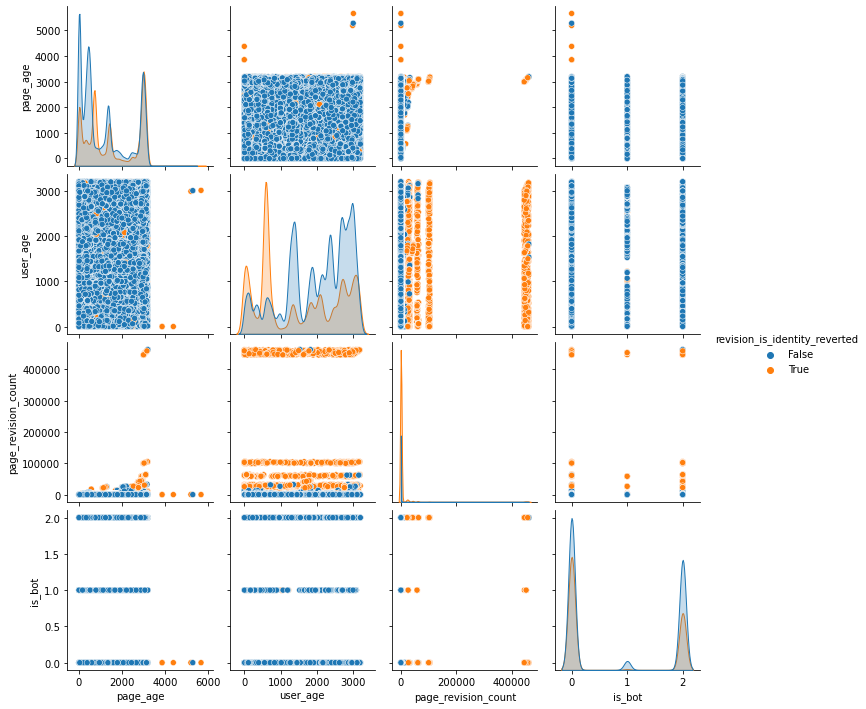

In [29]:
import seaborn as sns
sns.pairplot(editsSample2021BalencedClean[['page_age','user_age','page_revision_count','is_bot',y_col]].reset_index(),vars=['page_age','user_age','page_revision_count','is_bot'],hue=y_col)

[Text(0, 0.5, 'Account age (days)')]

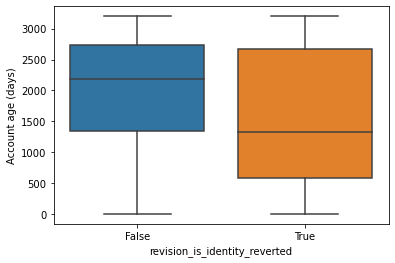

In [124]:
sns.boxplot(data=editsSample2021BalencedClean,x='revision_is_identity_reverted',y='user_age').set(
    ylabel='Account age (days)', 
    
)

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
features_to_drop = ['page_revision_count','page_age','user_age']
clf_no_user = RandomForestClassifier(random_state=0)
clf_no_user.fit(X_train.drop(features_to_drop,axis=1), y_train)


[[200804  31491]
 [ 23178 118796]]


NameError: name 'y_test_reverting' is not defined

In [34]:
y_pred_no_user = clf_no_user.predict(X_test.drop(features_to_drop,axis=1))
print(confusion_matrix(y_test, y_pred_no_user))
print(accuracy_score(y_test, y_pred_no_user))

[[198543  26543]
 [ 33752 115431]]
0.8388992943578015


In [36]:
sorted(zip(clf_no_user.feature_importances_,X_train.drop(features_to_drop,axis=1).columns))[-20:]

[(0.009363402923357782, 'summaryType_wbsetdescription-set'),
 (0.009417070158253287, 'prop_P31'),
 (0.009560270853806795, 'summaryType_wbsetclaim-create'),
 (0.010965921778207748, 'prop_P3782'),
 (0.011595082861105282, 'prop_P2860'),
 (0.012165784292579276, 'prop_P183'),
 (0.01238780313263257, 'prop_P646'),
 (0.015159126678353847, 'summaryType_wbcreateclaim-create'),
 (0.015341519212098026, 'summaryType_wbeditentity-create-item'),
 (0.017717585648406614, 'prop_P7902'),
 (0.019966598498041572, 'prop_'),
 (0.024473149250681673, 'prop_P2671'),
 (0.027851457340674037, 'prop_P9339'),
 (0.02834551993306892, 'summaryType_wbeditentity-update'),
 (0.04659270801365999, 'summaryType_undo'),
 (0.053668775572011454, 'summaryType_'),
 (0.06661811041014176, 'summaryType_wbsetlabel-add'),
 (0.0771644841733997, 'summaryType_wbeditentity-update-languages-short'),
 (0.12349096214066879, 'summaryType_wbsetdescription-add'),
 (0.16347100166119202, 'is_bot')]

In [39]:
#checking just with props
editsSample2021BalencedExperimentJustProp = pd.get_dummies(editsSample2021BalencedClean['prop'])

X_train_prop, X_test_prop, y_train_prop, y_test_prop= train_test_split(editsSample2021BalencedExperimentJustProp,editsSample2021BalencedClean[y_col] , test_size=0.20, random_state=42)

clf_prop = RandomForestClassifier(random_state=0)
clf_prop.fit(X_train_prop, y_train_prop)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
y_pred_prop = clf_prop.predict(X_test_prop)
print(confusion_matrix(y_test_prop, y_pred_prop))
print(accuracy_score(y_test_prop, y_pred_prop))

[[210720  14366]
 [104908  44275]]
0.6813147762705434


In [63]:
sorted(zip(clf_prop.feature_importances_,X_train_prop.columns))[-20:]

[(0.00712641345930418, 'P20'),
 (0.007292724624282837, 'P9047'),
 (0.007768788356613265, 'P348'),
 (0.008703755695153357, 'P850'),
 (0.010457897849744817, 'P8501'),
 (0.012002203498572957, 'P1268'),
 (0.014305035486201838, 'P31'),
 (0.015252124118069595, 'P361'),
 (0.01704158955406068, 'P1111'),
 (0.01885403628529224, ''),
 (0.021617905960457873, 'P9157'),
 (0.02523620003595896, 'P97'),
 (0.02928560651269477, 'P3602'),
 (0.03666313452115776, 'P646'),
 (0.03818614237555295, 'P3782'),
 (0.05769509359559863, 'P183'),
 (0.06161871268328917, 'P2860'),
 (0.06507426184641033, 'P7902'),
 (0.09885309033411595, 'P9339'),
 (0.10544467756519994, 'P2671')]

In [127]:
for p in sorted(zip(clf_prop.feature_importances_,X_train_prop.columns))[-10:]:
    print('**',p[1])

** P9157
** P97
** P3602
** P646
** P3782
** P183
** P2860
** P7902
** P9339
** P2671


In [76]:
props_dummies_to_plot = pd.get_dummies(editsSample2021BalencedClean[['prop','revision_is_identity_reverted']])
props_important = ['prop_'+x[1] for x in sorted(zip(clf_prop.feature_importances_,X_train_prop.columns))[-20:]]

props_dummies_to_plot.corr()
#sns.kdeplot(data=props_dummies_to_plot[props_important][0:50000],norm=)

KeyboardInterrupt: 

#### Analyzing the probability of props to exists in reverts or nor reverts


In [81]:
editsSample2021BalencedClean

is_bot   prop                          summaryType  page_age  \
0             2  P2860                      wbsetclaimvalue    1833.0   
1             0                         wbeditentity-update    2886.0   
2             0                                        undo    3113.0   
3             2                         wbeditentity-update    2417.0   
4             0   P161                    wbsetclaim-create     442.0   
...         ...    ...                                  ...       ...   
1242157       0                         wbeditentity-update      40.0   
1242158       0   P921                   wbsetreference-add     596.0   
1242159       2         wbeditentity-update-languages-short     335.0   
1242160       0                        wbsetdescription-add     381.0   
1242161       0                            wbsetaliases-add    3131.0   

         user_age  page_revision_count  revision_is_identity_reverted  
0          2440.0                   90                           True  
1           583.0                   61                           True  
2          3134.0                  140                           True  
3          1036.0                   49                           True  
4           582.0                   34                           True  
...           ...                  ...                            ...  
1242157    2964.0                    2                          False  
1242158     113.0                    6                          False  
1242159    1783.0                    4                          False  
1242160    1452.0                    6                          False  
1242161     832.0                  253                          False  

[1871342 rows x 7 columns]

In [105]:
props_reverted = pd.DataFrame(editsSample2021BalencedClean[editsSample2021BalencedClean['revision_is_identity_reverted']==1]['prop'].value_counts())
props_reverted = props_reverted[props_reverted['prop'] > 100]
props_no_reverted = pd.DataFrame(editsSample2021BalencedClean[editsSample2021BalencedClean['revision_is_identity_reverted']==0]['prop'].value_counts())
props_no_reverted = props_no_reverted[props_no_reverted['prop'] > 100]


In [121]:
props_comparison = props_no_reverted.join(props_reverted,lsuffix='_no_reverted',rsuffix='_reverted',how='left').fillna(0)
props_comparison['ratio_reverted'] = props_comparison['prop_reverted'] / (props_comparison['prop_no_reverted'] +props_comparison['prop_reverted'])

In [122]:
props_comparison.sort_values('ratio_reverted',ascending=False)[0:20]

prop_no_reverted  prop_reverted  ratio_reverted
P7902               131        13500.0        0.990390
P9339               208        20684.0        0.990044
P183                140        12158.0        0.988616
P3602               129         6272.0        0.979847
P2860               674        14107.0        0.954401
P8814               173         1514.0        0.897451
P400                192         1099.0        0.851278
P348                562         2710.0        0.828240
P2302               139          610.0        0.814419
P20                 626         2702.0        0.811899
P3373               240          960.0        0.800000
P154                137          523.0        0.792424
P2397               151          558.0        0.787024
P361               1776         6297.0        0.780007
P460                130          449.0        0.775475
P749                103          336.0        0.765376
P2002               425         1292.0        0.752475
P1366               134          395.0        0.746692
P1705               816         2338.0        0.741281
P268                291          813.0        0.736413

In [ ]:
P790

In [102]:
set(props_reverted.index) - set(props_no_reverted.index)

{'P3680', 'P688', 'P7328', 'P8987', 'P9049', 'P9525'}

# Computing reverting



In [127]:
editsReverting2021Pd = editsFrom2021.where(editsFrom2021['revision_is_identity_revert'] == True).toPandas()

In [147]:
editsReverting2021Pd.shape

(842757, 16)

In [148]:
editsSample2021BalencedReverting = pd.concat([editsReverting2021Pd,editsSample2021Pd.sample(n=editsReverting2021Pd.shape[0])])

In [149]:
editsSample2021BalencedReverting['revision_is_identity_revert'].value_counts()

True     847848
False    837666
Name: revision_is_identity_revert, dtype: int64

In [165]:
#I use the properties from the previous experting (reverted), to be able later to join all Togheter in one
editsSample2021BalencedCleanReverting = editsSample2021BalencedReverting[editsSample2021BalencedReverting['prop'].isin(propsTop)]
editsSample2021BalencedCleaneditsSample2021BalencedReverting = editsSample2021BalencedCleanReverting[editsSample2021BalencedCleanReverting['summaryType'].isin(summaryTypesTop)]
# defining training and label col
training_cols = ['is_bot','prop','summaryType','page_age','user_age','page_revision_count']
y_col = 'revision_is_identity_revert'
cols_to_keep = training_cols + [y_col]
editsSample2021BalencedCleanReverting= editsSample2021BalencedCleanReverting[cols_to_keep]

In [166]:
editsSample2021BalencedCleanReverting['revision_is_identity_revert'].value_counts()

True     827006
False    822195
Name: revision_is_identity_revert, dtype: int64

In [167]:
editsSample2021BalencedCleanReverting.dropna(inplace=True)
editsSample2021BalencedExperimentReverting = pd.get_dummies(editsSample2021BalencedCleanReverting[training_cols])

X_train_reverting, X_test_reverting, y_train_reverting, y_test_reverting = train_test_split(editsSample2021BalencedExperimentReverting,editsSample2021BalencedCleanReverting[y_col] , test_size=0.20, random_state=42)

In [172]:
editsSample2021BalencedCleanReverting['revision_is_identity_revert'].value_counts()

False    764055
True     681686
Name: revision_is_identity_revert, dtype: int64

In [173]:
clf_reverting = RandomForestClassifier(random_state=0)
clf_reverting.fit(X_train_reverting, y_train_reverting)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [175]:
y_pred_reverting = clf_reverting.predict(X_test_reverting)
print(confusion_matrix(y_test_reverting, y_pred_reverting))
print(accuracy_score(y_test_reverting, y_pred_reverting))

[[149978   3112]
 [  2425 133634]]
0.9808507032706321


In [188]:
sorted(zip(clf_reverting.feature_importances_,X_train_reverting.columns))[-20:]

[(0.006985802254422807, 'summaryType_wbsetqualifier-add'),
 (0.007020171109436999, 'prop_P2214'),
 (0.007789805725967659, 'prop_P3606'),
 (0.007882421140964215, 'summaryType_wbsetdescription-set'),
 (0.011614180761238949, 'summaryType_restore'),
 (0.013220966266287111, 'summaryType_wbsetreference-add'),
 (0.015013297620103465, 'summaryType_wbeditentity-update'),
 (0.016089219233306185, 'summaryType_wbeditentity-update-languages-short'),
 (0.019105996710564708, 'summaryType_wbsetclaim-create'),
 (0.02283680093463263, 'prop_'),
 (0.03205769291142832, 'summaryType_wbsetdescription-add'),
 (0.040161472877874464, 'summaryType_wbsetlabel-add'),
 (0.041223570283724316, 'is_bot'),
 (0.042650274780947406, 'summaryType_'),
 (0.04446321186093318, 'summaryType_wbcreateclaim-create'),
 (0.06231140614171291, 'summaryType_wbremoveclaims-remove'),
 (0.08332457907852842, 'page_revision_count'),
 (0.10783341212188607, 'summaryType_undo'),
 (0.14186691063491957, 'page_age'),
 (0.1890098243117535, 'user_a

<AxesSubplot:xlabel='revision_is_identity_revert', ylabel='user_age'>

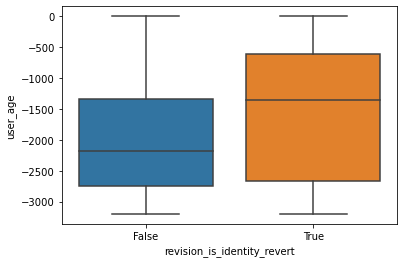

In [178]:
sns.boxplot(data=editsSample2021BalencedCleanReverting,x='revision_is_identity_revert',y='user_age')

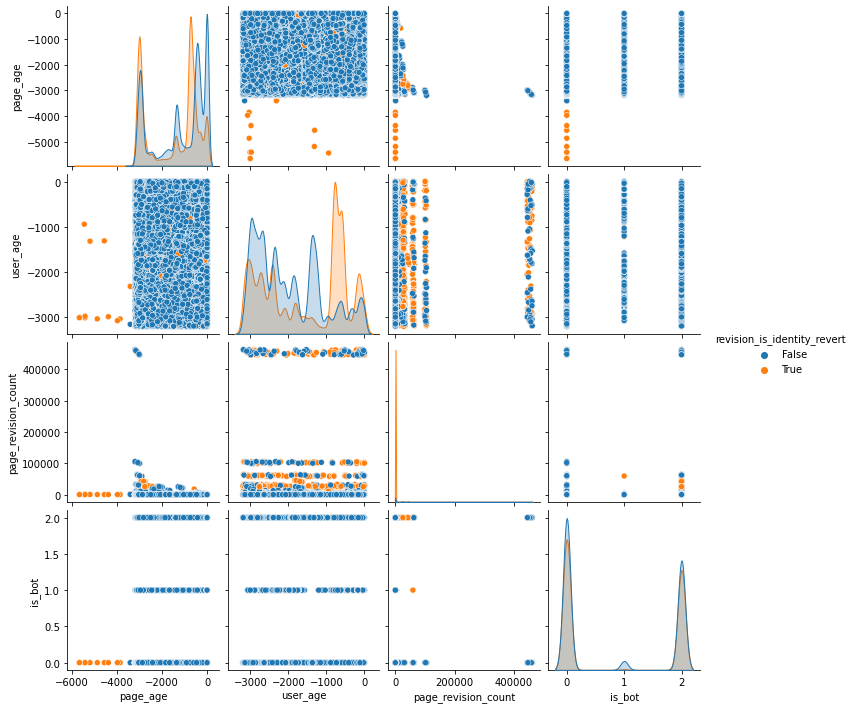

In [179]:
sns.pairplot(editsSample2021BalencedCleanReverting[['page_age','user_age','page_revision_count','is_bot',y_col]].reset_index(),vars=['page_age','user_age','page_revision_count','is_bot'],hue=y_col)

# TAG UI

In [14]:
#using revs since 2021-10, because the wikidata-iu is already implemented
revs  = spark.sql('''SELECT  TIMESTAMP(event_timestamp), 
                                    page_title,
                                    event_comment,
                                    revision_parent_id, 
                                    SIZE(event_user_is_bot_by) as is_bot,
                                    revision_is_identity_reverted,
                                    revision_is_identity_revert,
                                    revision_first_identity_reverting_revision_id,
                                    revision_seconds_to_identity_revert,
                                    event_user_text,
                                    event_user_revision_count,
                                    page_revision_count,
                                    page_seconds_since_previous_revision,
                                    datediff(TIMESTAMP(event_timestamp),TIMESTAMP(event_user_creation_timestamp)) AS user_age,
                                    datediff(TIMESTAMP(event_timestamp),TIMESTAMP(page_first_edit_timestamp)) AS page_age,
                                    EXPLODE(revision_tags)
                                    
            FROM wmf.mediawiki_history WHERE event_entity = 'revision' AND page_namespace = 0 
            AND wiki_db = 'wikidatawiki' AND snapshot = '2022-01'  AND
            TO_TIMESTAMP(event_timestamp) < TO_TIMESTAMP("2021-10-01") 
            AND SIZE(event_user_is_bot_by) = 0 ''')
from pyspark.sql.functions import explode


revs_ui = revs.where(revs['col'] == 'wikidata-ui')
revs_ui = revs_ui.withColumn("summaryType", findCommentSummary(F.col("event_comment")))
revs_ui = revs_ui.withColumn("prop", findProp(F.col("event_comment")))
revs_ui = revs_ui.drop('event_comment')
revs_ui.cache()

DataFrame[event_timestamp: timestamp, page_title: string, revision_parent_id: bigint, is_bot: int, revision_is_identity_reverted: boolean, revision_is_identity_revert: boolean, revision_first_identity_reverting_revision_id: bigint, revision_seconds_to_identity_revert: bigint, event_user_text: string, event_user_revision_count: bigint, page_revision_count: bigint, page_seconds_since_previous_revision: bigint, user_age: int, page_age: int, col: string, summaryType: string, prop: string]

In [23]:
revs_ui.count()

2568068

## Reverts with tag ui (new)

In [ ]:
revs_ui_reverted = revs_ui.where(revs_ui['revision_is_identity_reverted'] == True).toPandas()

In [9]:
revs_ui_reverted.shape

(31389, 17)

In [10]:
31389/2568068

0.01222280718423344

In [5]:
revs_ui_sample = revs_ui.sample(0.012).toPandas()

In [ ]:
import pandas as pd
revs_ui_sample_Balenced = pd.concat([revs_ui_reverted,revs_ui_sample])

In [34]:
revs_ui_sample_Balenced['revision_is_identity_reverted'].value_counts()

True     31755
False    30495
Name: revision_is_identity_reverted, dtype: int64

In [36]:
y_col = 'revision_is_identity_reverted'


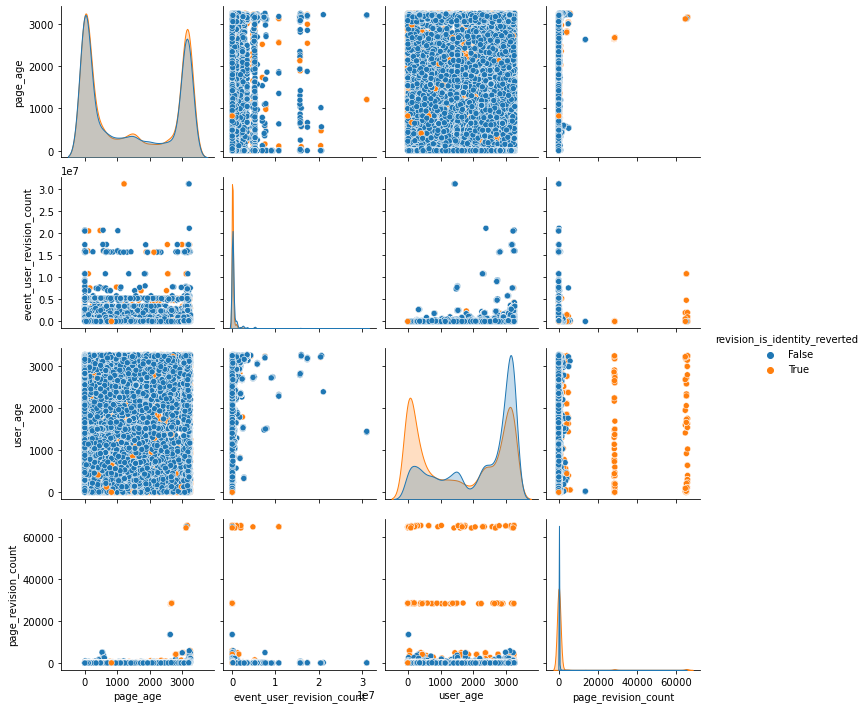

In [40]:
import seaborn as sns
sns.pairplot(revs_ui_sample_Balenced[['page_age','user_age','page_revision_count',
                                      'event_user_revision_count',y_col]].reset_index(),vars=['page_age',
                                                                                              'event_user_revision_count',
                                                                                              'user_age',
                                                                                              'page_revision_count'],hue=y_col)

In [44]:
import numpy as np
revs_ui_sample_Balenced['event_user_revision_count_log'] = revs_ui_sample_Balenced.event_user_revision_count.apply(np.log)

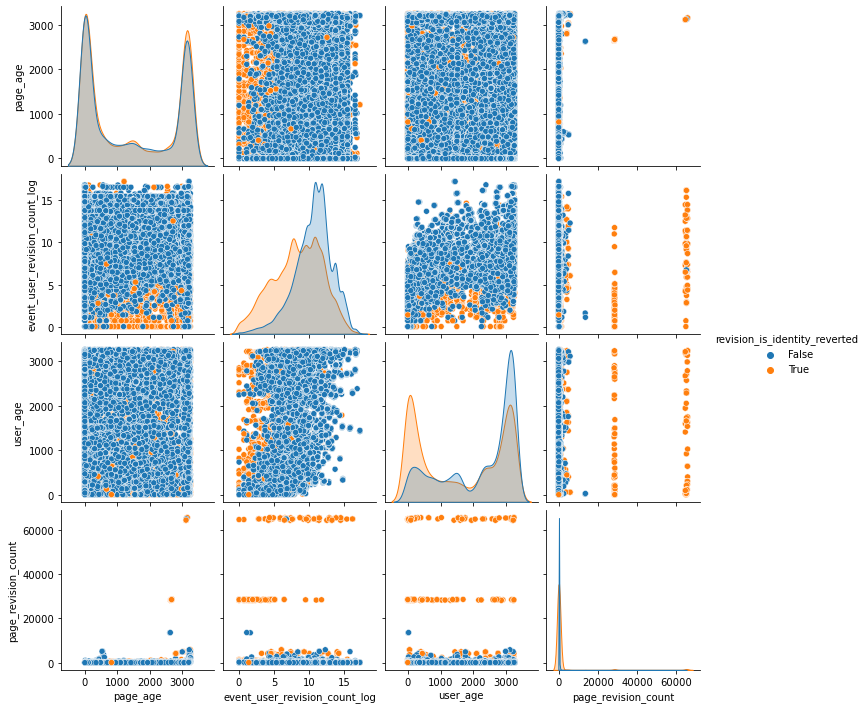

In [45]:
import seaborn as sns
sns.pairplot(revs_ui_sample_Balenced[['page_age','user_age','page_revision_count',
                                      'event_user_revision_count_log',y_col]].reset_index(),vars=['page_age',
                                                                                              'event_user_revision_count_log',
                                                                                              'user_age',
                                                                                              'page_revision_count'],hue=y_col)

<AxesSubplot:xlabel='revision_is_identity_reverted', ylabel='user_age'>

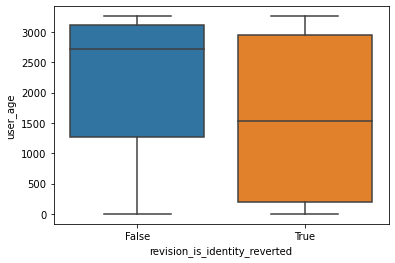

In [47]:
sns.boxplot(data=revs_ui_sample_Balenced,x=y_col,y='user_age')

<AxesSubplot:xlabel='revision_is_identity_reverted', ylabel='event_user_revision_count_log'>

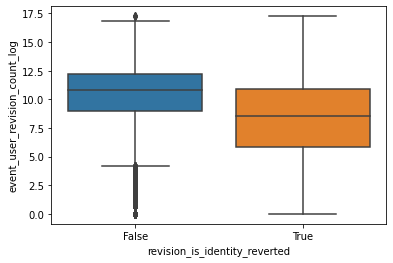

In [49]:
sns.boxplot(data=revs_ui_sample_Balenced,x=y_col,y='event_user_revision_count_log')

In [ ]:
#Here I keep the most common classes for caterorical types
revs_ui_summaryTypesTop = revs_ui_sample_Balenced.summaryType.value_counts().reset_index(name="count").query("count > 100")['index'].tolist()
revs_ui_propsTop = revs_ui_sample_Balenced.prop.value_counts().reset_index(name="count").query("count > 100")['index']
revs_ui_sample_BalencedClean = revs_ui_sample_Balenced[revs_ui_sample_Balenced['prop'].isin(revs_ui_propsTop)]
revs_ui_sample_BalencedClean = revs_ui_sample_BalencedClean[revs_ui_sample_BalencedClean['summaryType'].isin(revs_ui_summaryTypesTop)]
# defining training and label col
training_cols = ['is_bot','prop','summaryType','page_age','user_age','page_revision_count']
y_col = 'revision_is_identity_reverted'
cols_to_keep = training_cols + [y_col]
revs_ui_sample_BalencedClean = revs_ui_sample_BalencedClean[cols_to_keep]
                                                         

In [62]:
revs_ui_sample_BalencedClean

is_bot  prop              summaryType  page_age  user_age  \
0           0   P18    wbremoveclaims-remove      3120      93.0   
3           0  P527    wbremoveclaims-remove      2155    1861.0   
4           0  P268        wbsetclaim-update      1025    2350.0   
5           0        wbsetdescription-remove      3188    3243.0   
9           0  P106        wbsetclaim-create      3196       4.0   
...       ...   ...                      ...       ...       ...   
30856       0           wbsetdescription-add      3211     361.0   
30857       0                 wbsetlabel-set      3172    2668.0   
30858       0                 wbsetlabel-set      3056    3061.0   
30859       0           wbsetdescription-set       821       0.0   
30860       0  P856        wbsetclaim-update      3203     736.0   

       page_revision_count  revision_is_identity_reverted  
0                    64774                           True  
3                       44                           True  
4                       63                           True  
5                       88                           True  
9                      103                           True  
...                    ...                            ...  
30856                   89                          False  
30857                   73                          False  
30858                   13                          False  
30859                   65                           True  
30860                  134                          False  

[45399 rows x 7 columns]

In [72]:
from sklearn.model_selection import train_test_split
y_col = 'revision_is_identity_reverted'
revs_ui_sample_BalencedCleanExperiment = pd.get_dummies(revs_ui_sample_BalencedClean[training_cols])

X_train, X_test, y_train, y_test = train_test_split(revs_ui_sample_BalencedCleanExperiment.fillna(0),revs_ui_sample_BalencedClean[y_col] , test_size=0.20, random_state=42)

In [73]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [78]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3809 1051]
 [1143 3077]]
0.7583700440528635


In [82]:
sorted(zip(clf.feature_importances_,X_train.columns))[-10:]

[(0.00702043530179124, 'summaryType_wbsetclaim-create'),
 (0.00910458528202965, 'summaryType_wbremoveclaims-remove'),
 (0.009445046928611582, 'summaryType_wbsetaliases-add'),
 (0.014901230723854752, 'summaryType_wbsetdescription-add'),
 (0.01788767139909128, 'summaryType_'),
 (0.022476704328922383, 'summaryType_wbsetlabel-add'),
 (0.023233843999529716, 'summaryType_wbsetsitelink-remove'),
 (0.19391786777850195, 'page_age'),
 (0.2232950172768442, 'page_revision_count'),
 (0.27681151582195623, 'user_age')]

In [85]:
from sklearn.ensemble import RandomForestClassifier
clf_few = RandomForestClassifier(random_state=0)
clf_few.fit(X_train[['page_age','page_revision_count','user_age']], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [88]:
y_pred_few = clf_few.predict(X_test[['page_age','page_revision_count','user_age']])
print(confusion_matrix(y_test, y_pred_few))
print(accuracy_score(y_test, y_pred_few))

[[3635 1225]
 [1411 2809]]
0.7096916299559471


In [92]:
revs_ui_sample_BalencedClean[['page_age','page_revision_count','user_age',y_col]].corr()

page_age  page_revision_count  user_age  \
page_age                       1.000000             0.118218  0.081752   
page_revision_count            0.118218             1.000000 -0.104515   
user_age                       0.081752            -0.104515  1.000000   
revision_is_identity_reverted  0.010982             0.106299 -0.270523   

                               revision_is_identity_reverted  
page_age                                            0.010982  
page_revision_count                                 0.106299  
user_age                                           -0.270523  
revision_is_identity_reverted                       1.000000

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf_user = RandomForestClassifier(random_state=0)
clf_user.fit(X_train[['user_age']], y_train)

y_pred_user_age= clf_user.predict(X_test[['user_age']])
print(confusion_matrix(y_test, y_pred_user_age))
print(accuracy_score(y_test, y_pred_user_age))

[[3795 1065]
 [2115 2105]]
0.6497797356828194


### Probability of being reverted according user_count

In [22]:
from pyspark.sql import functions as F  
prob_rev_count = revs_ui.groupby("event_user_revision_count").agg(F.avg(F.col("revision_is_identity_reverted").cast("long")),F.stddev(F.col("revision_is_identity_reverted").cast("long"))).toPandas()

<AxesSubplot:title={'center':'Probability of being reverted '}, xlabel='event_user_revision_count'>

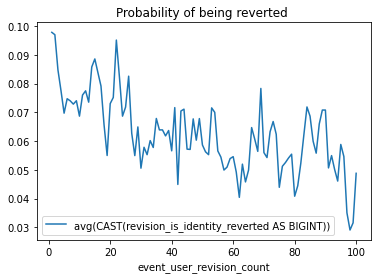

In [20]:
prob_rev_count.sort_values('event_user_revision_count')[0:100].plot(x='event_user_revision_count',y='avg(CAST(revision_is_identity_reverted AS BIGINT))',
                                                                   title='Ratio of reverted edits by user_count ')

## Reverting ui

In [24]:
#print 
revs_ui.where((revs_ui['revision_is_identity_revert'] == True) & (revs_ui['is_bot'] == 0)).\
            select('prop').groupBy('prop').count().orderBy('count', ascending=False).show()

+-----+-----+
| prop|count|
+-----+-----+
|     | 4336|
|  P31|  892|
|  P18|  597|
| P106|  332|
|  P21|  287|
| P373|  284|
|  P39|  251|
| P279|  249|
|P8411|  213|
| P735|  212|
| P569|  209|
| P856|  208|
| P734|  197|
| P674|  189|
|  P17|  171|
| P625|  151|
| P131|  151|
| P921|  150|
|  P19|  142|
|P2671|  130|
+-----+-----+
only showing top 20 rows



In [ ]:
revs_ui_reverting = revs_ui.where(revs_ui['revision_is_identity_revert'] == True).toPandas()

In [ ]:
revs_ui_sample_reverting_Balanced = pd.concat([revs_ui_reverting,revs_ui_sample]) #using the sample from reverted

In [24]:
revs_ui.where(revs_ui['revision_is_identity_revert'] == True).count()

21362